# The purpose of this notebook is to calculate the Weight of Evidence (WOE) and Information Value (IV) for each predictor variable in our cleaned dataset.

### WOE and IV help us identify which variables have the strongest predictive power in distinguishing good (non-default) vs bad (default) borrowers for our Elder-Care Support Loan credit scorecard.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)

DATA_PATH = Path("merged_applicant_and_bureau_cleaned.csv")   
OUT_DIR = Path("woe_iv_outputs")                              # local subfolder for outputs
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
TARGET_COL = "TARGET"   # 0 = good, 1 = bad 

In [3]:
# Load your cleaned dataset
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])  # show first 20 columns
df[TARGET_COL].value_counts(dropna=False)
df.head()


Shape: (254358, 28)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Function takes in a data frame for a variable with columns: variable values, 'TARGET' values, bin range corresponding to varaible value.

In [4]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data

# # test the function
# df_bin_data = df.loc[:,('AMT_CREDIT', 'TARGET')].copy()
# df_bin_data['Bin_Range'] = pd.qcut(df['AMT_CREDIT'], q=20)
# woe_iv(df_bin_data)

# Function to calculate WOE, IV and plot IV

In [5]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    

IV for AMT_CREDIT with 5 bins: 0.0402


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\1750641458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

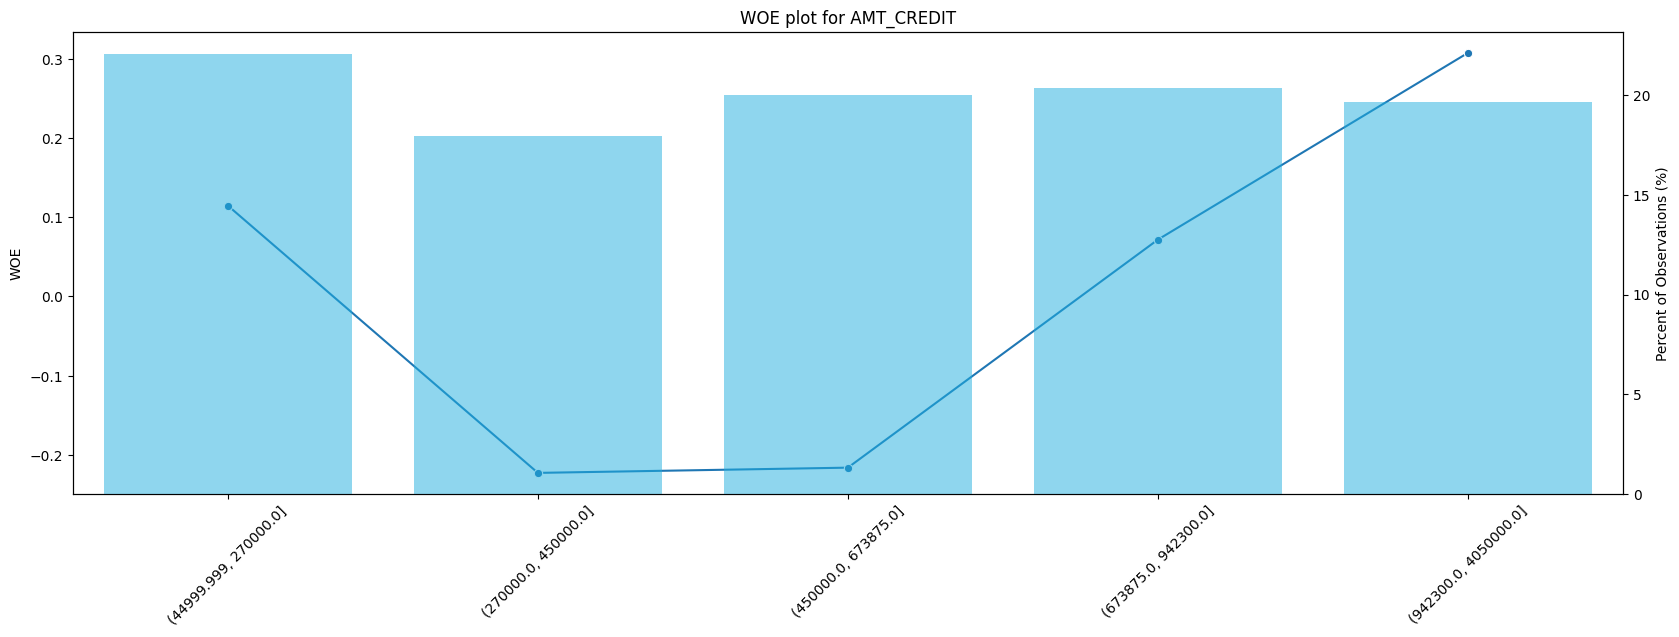

In [6]:
# test the function - create a copy first
variable = 'AMT_CREDIT'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# Coarse classing Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT with 4 categories: 0.0235


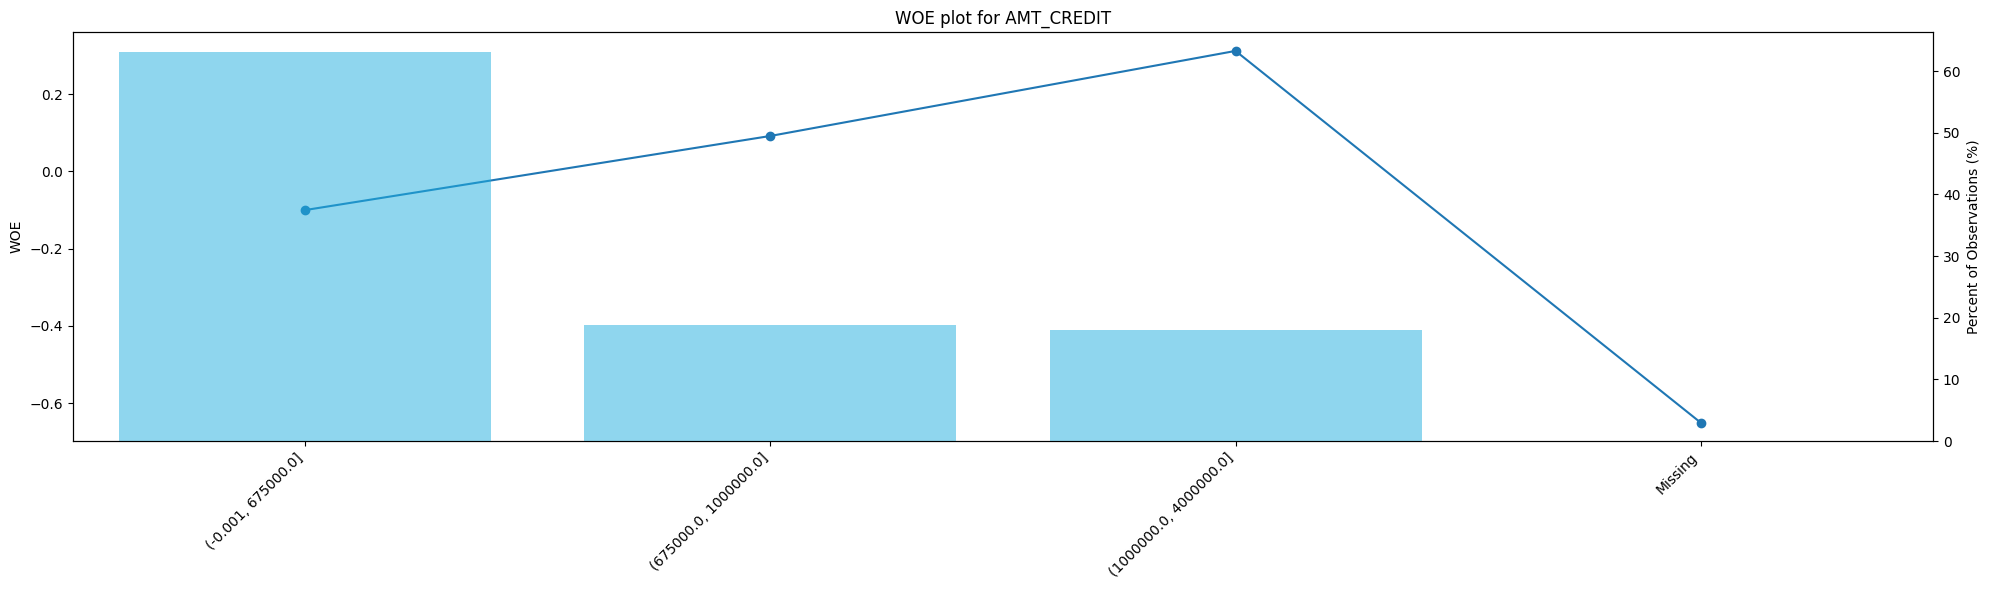

In [29]:
# sample code

bin_edges = [0,675000, 1000000, 4000000]
variable = 'AMT_CREDIT'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DAYS_EMPLOYED

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3718830670.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for DAYS_EMPLOYED with 6 bins: 0.0942


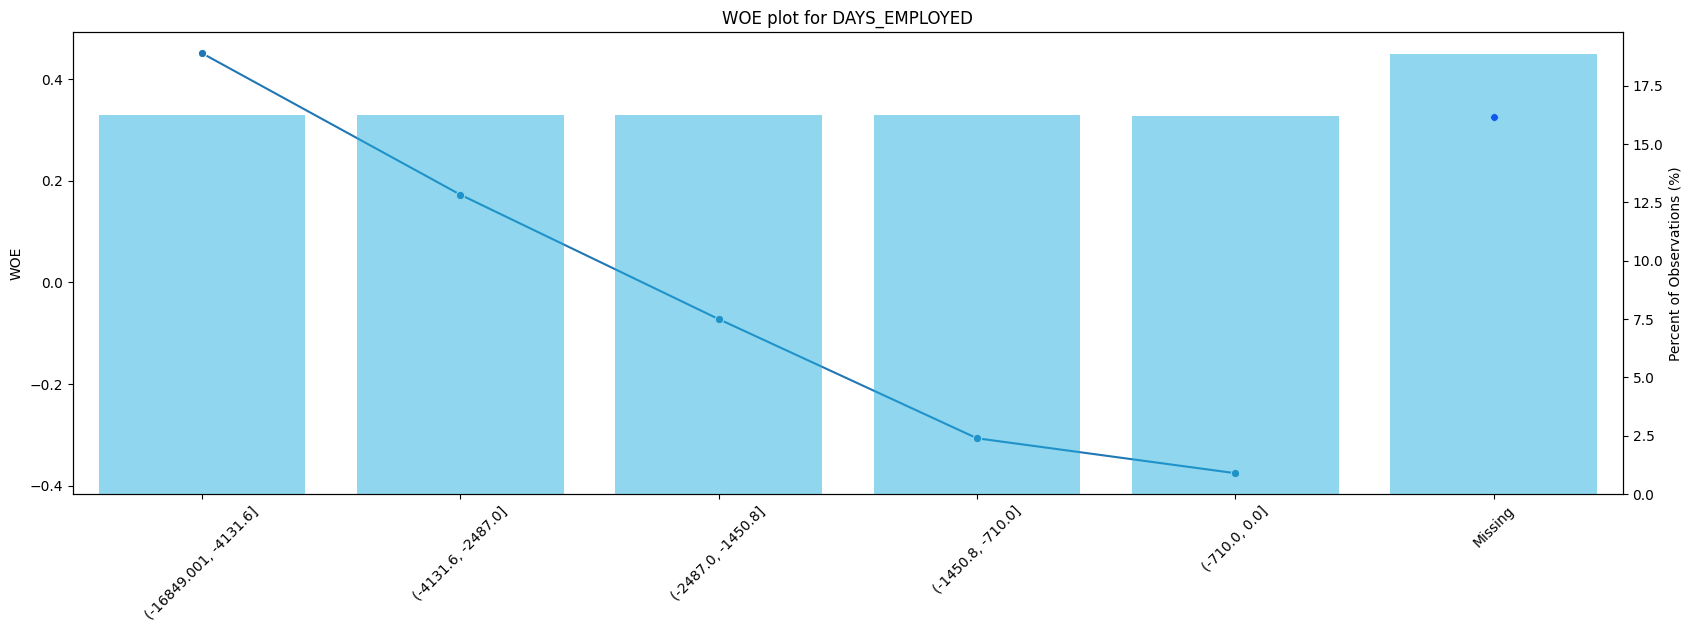

In [8]:
# test the function - create a copy first
variable = 'DAYS_EMPLOYED'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DAYS_EMPLOYED with 4 bins: 0.0894


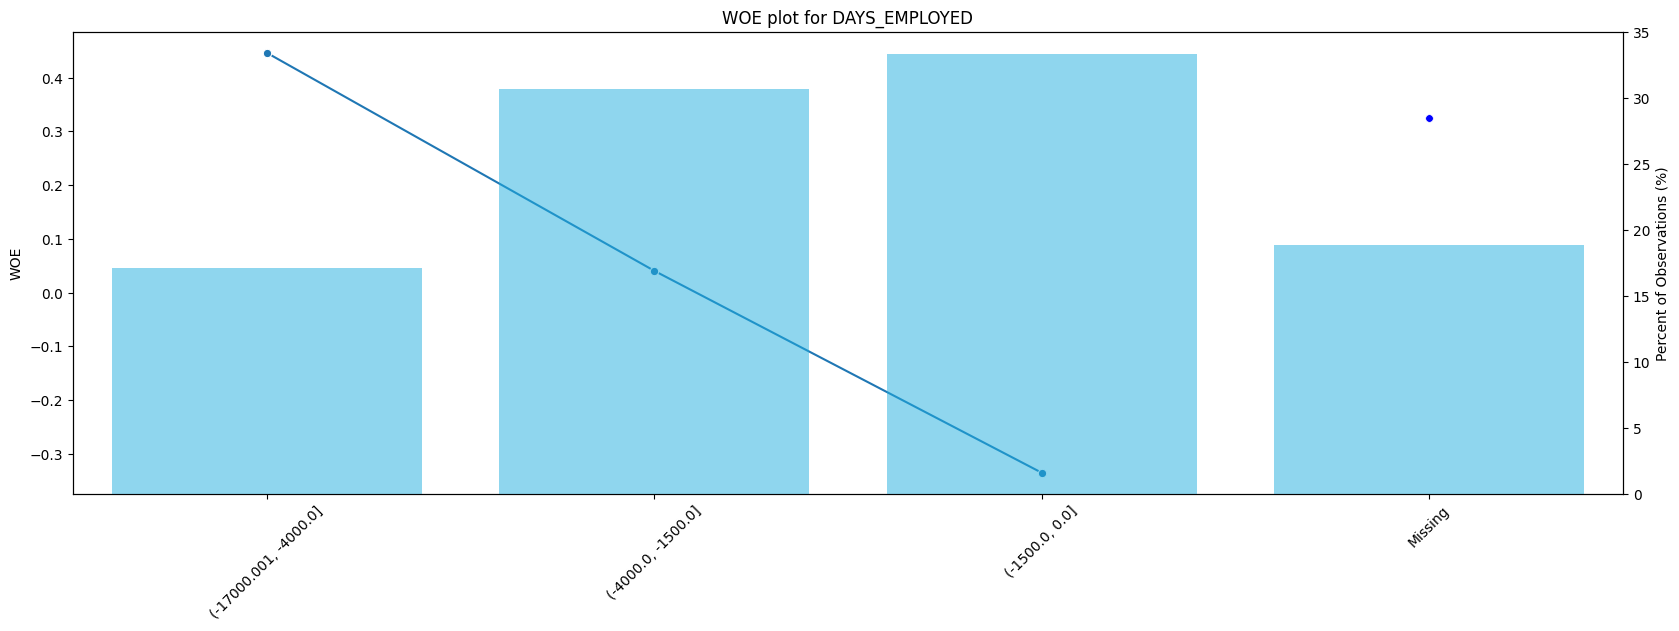

In [9]:
# sample code

bin_edges = [-17000, -4000, -1500, 0]
variable = 'DAYS_EMPLOYED'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DEBT_RATIO

### AMT_CREDIT_SUM_DEBT_sum

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3052190614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AMT_CREDIT_SUM_DEBT_sum with 6 bins: 0.0479


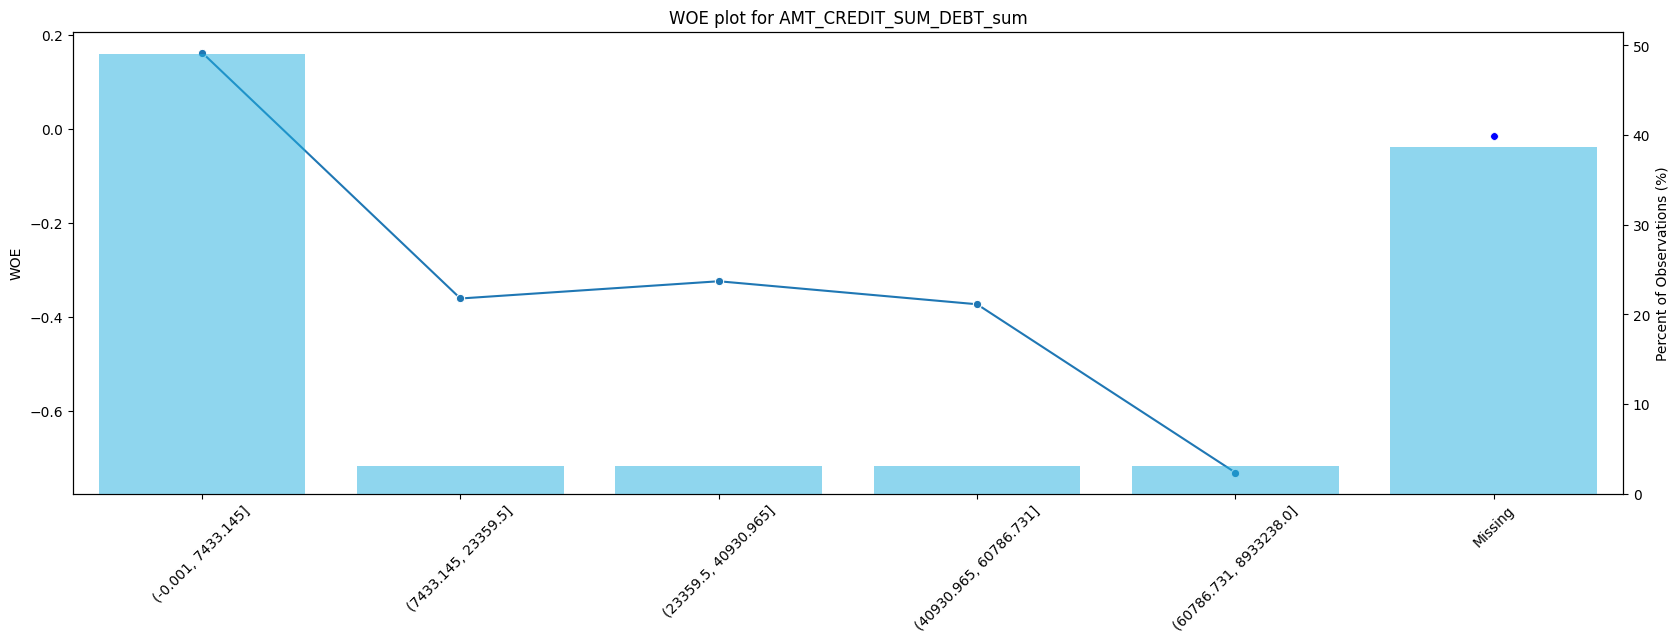

In [10]:
# test the function - create a copy first
variable = 'AMT_CREDIT_SUM_DEBT_sum'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates="drop")
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT_SUM_DEBT_sum with 5 bins: 0.0483


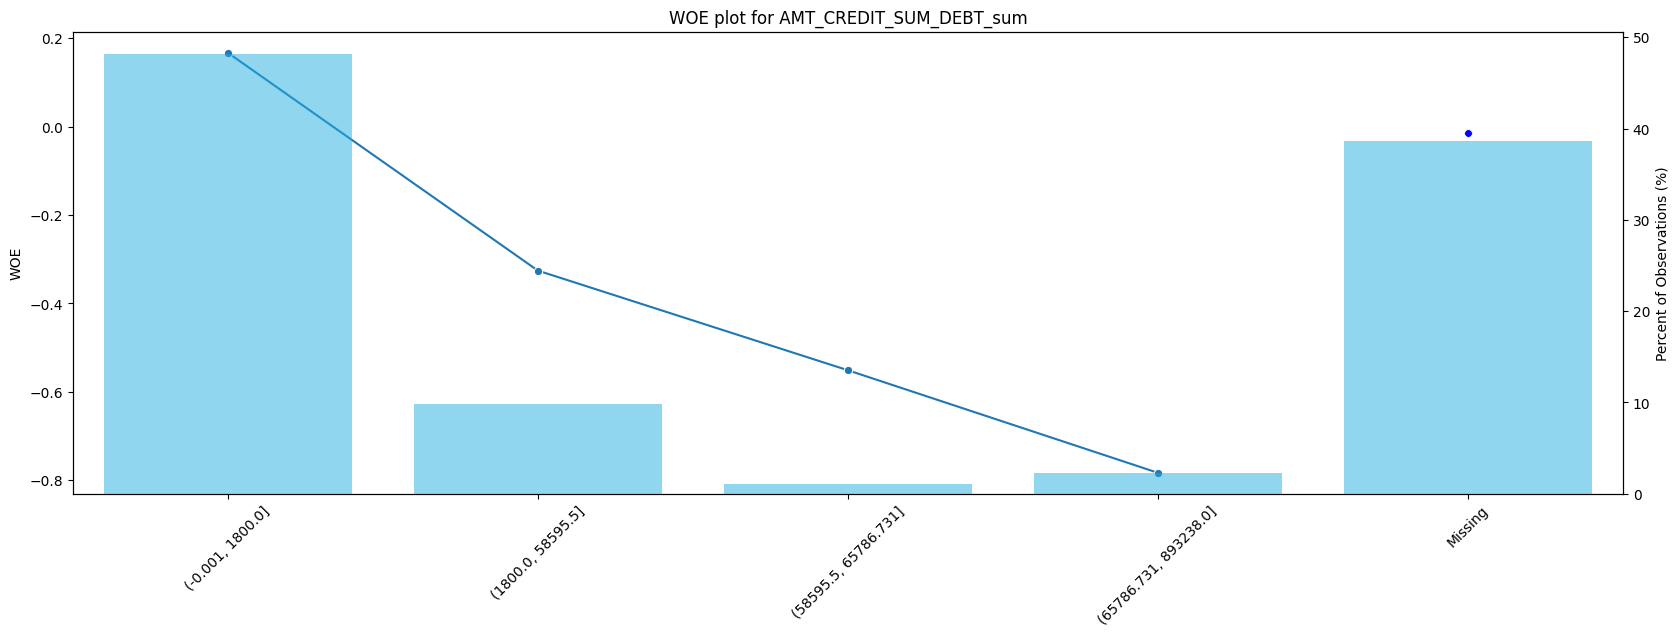

In [11]:
# sample code

bin_edges = [0, 1800, 58595.5, 65786.731, 893238.0]
variable = 'AMT_CREDIT_SUM_DEBT_sum'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AGE

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\2776209989.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AGE with 6 bins: 0.0539


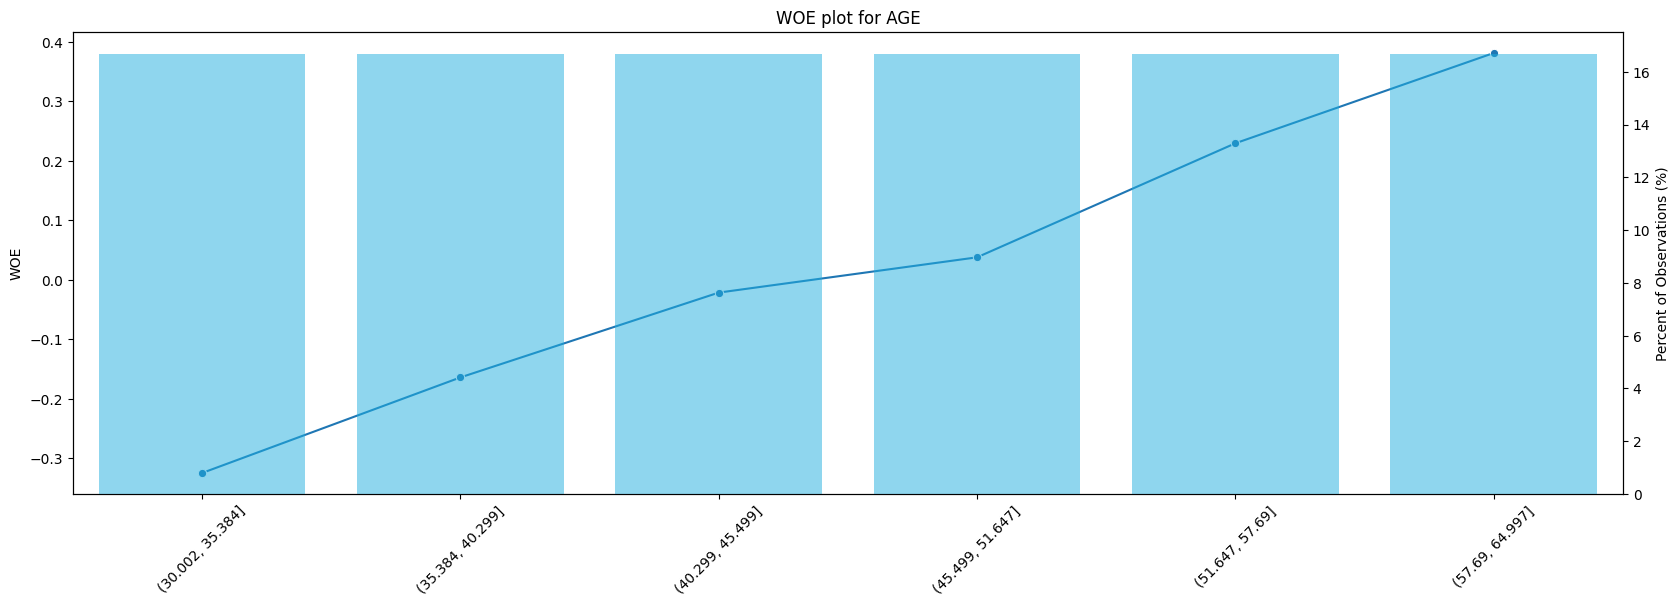

In [12]:
# test the function - create a copy first
variable = 'AGE'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=6)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AGE with 4 bins: 0.0499


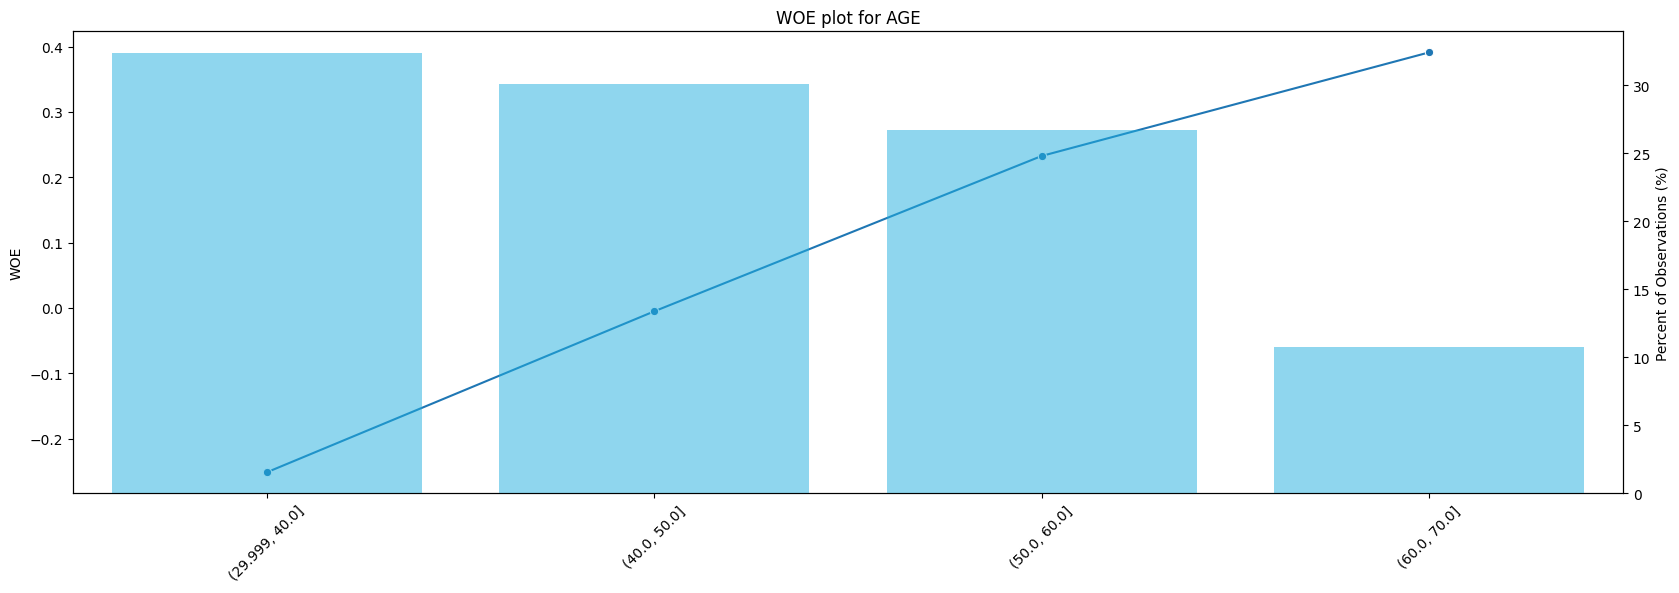

In [13]:
# sample code

bin_edges = [30, 40, 50, 60,  70]
variable = 'AGE'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### CREDIT_ACTIVE_Active

IV for CREDIT_ACTIVE_Active with 5 bins: 0.0191


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\446180054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


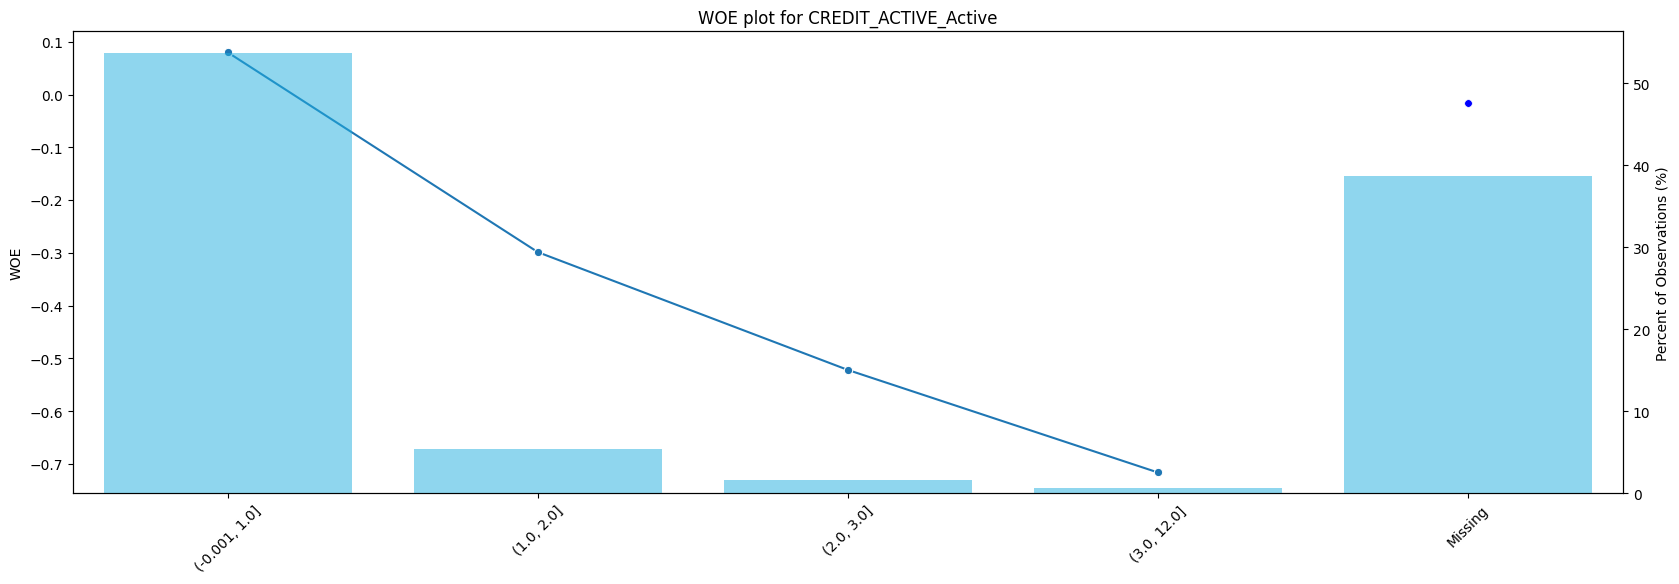

In [14]:
# test the function - create a copy first
variable = 'CREDIT_ACTIVE_Active'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=30, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for CREDIT_ACTIVE_Active with 4 categories: 0.0183


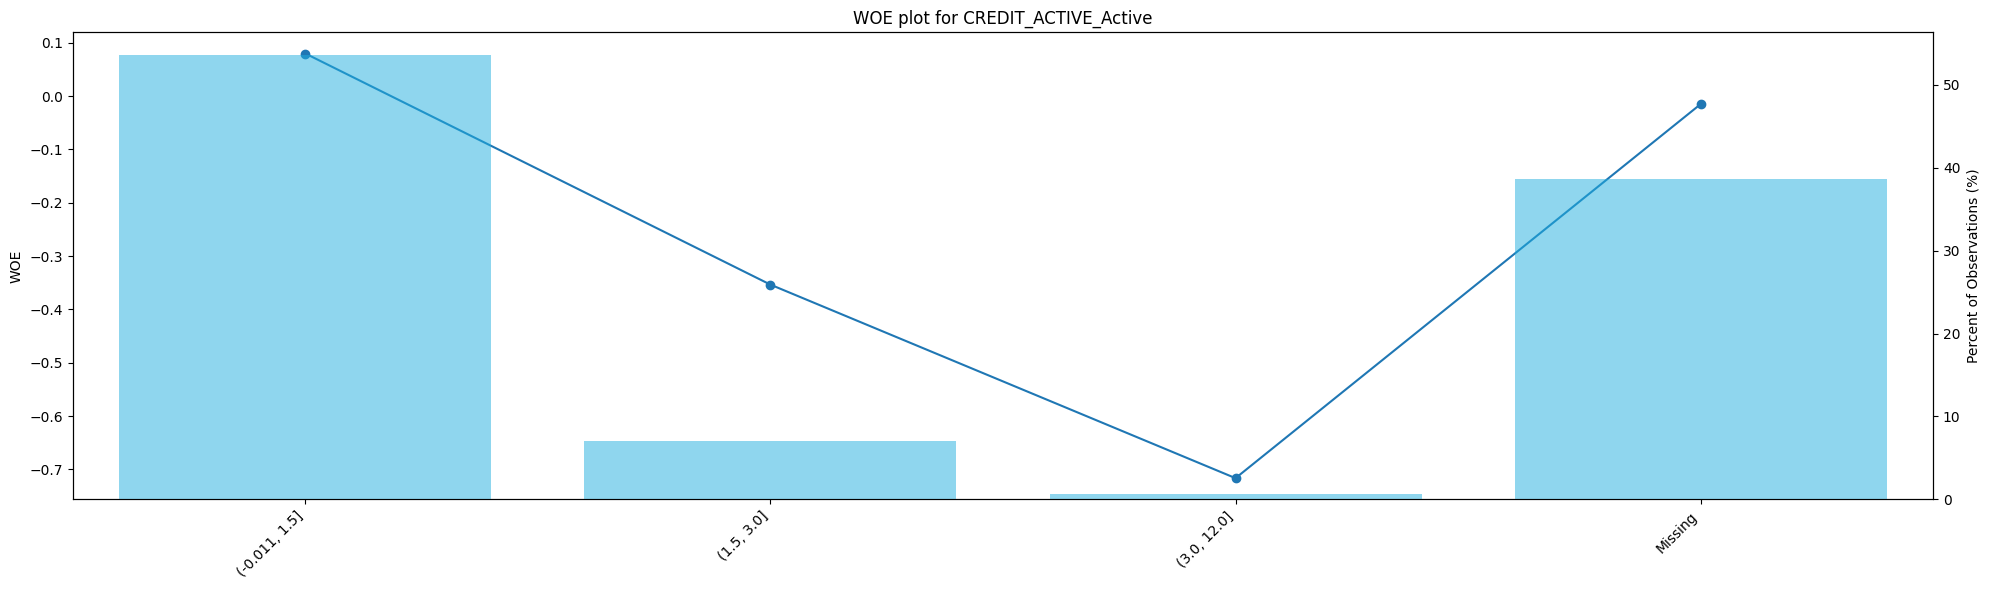

In [37]:
# sample code

bin_edges = [-0.01, 1.5, 3.0, 12.0]
variable = 'CREDIT_ACTIVE_Active'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_GOODS_PRICE	

### AMT_ANNUITY		

### CREDIT_ACTIVE_Closed	

### CREDIT_TYPE_Credit card		

### FLAG_OWN_CAR	

### CREDIT_TYPE_Microloan	

# Categorical
# Categorical WOE → Coarse Classing (3 Bands)

**Goal.** Turn high-cardinality categorical variables into 3 interpretable risk bands:
**High** (riskiest), **Moderate**, **Low** (safest), using Weight-of-Evidence (WOE).

**Why High/Moderate/Low?**
- **Stability:** Many small categories are noisy/sparse. Merging by WOE produces stable bins.
- **Monotonicity:** WOE is log-odds. Grouping by WOE ranking helps preserve a monotonic relation with risk,
  which logistic regression likes.
- **Interpretability:** “High/Moderate/Low risk” is easy to explain to stakeholders and for policy cutoffs.
- **Less overfitting:** Fewer, larger bins reduce variance and leakage from tiny groups.

Workflow:
1) Compute WOE/IV per bin (`woe_iv`), and plot (`woe_iv_plot`).
2) Build 3 bands by **ordering categories on WOE** and merging by **population tertiles**.
3) Plot WOE of the 3 bands to verify a **High → Moderate → Low** trend.


In [16]:
def woe_iv(data):
    working_data = data.copy() 

    ### CHANGED (line added): make sure TARGET is numeric 0/1 so sum works
    working_data['TARGET'] = pd.to_numeric(working_data['TARGET'], errors='coerce').fillna(0).astype(int)

    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    ### CHANGED (select only TARGET before summing; do not sum the whole DF)
    variable_data['Events'] = working_data.groupby('Bin_Range')['TARGET'].sum().values

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    k = len(variable_data)
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * k)
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * k)
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()


    variable_data['EventRate'] = variable_data['Events'] / variable_data['Count']
    
    return variable_data



def woe_iv_plot(data, variable_name):
    """
    Plots WOE (line, left axis) and % of observations (bars, right axis).
    Enforces x-axis order = ['High','Moderate','Low'] whenever those labels exist.
    """
    variable_data = woe_iv(data).copy()

    # Desired band order (use only the ones that exist in this variable)
    desired_full = ['High', 'Moderate', 'Low']
    present = [c for c in desired_full if c in variable_data['Bin_Range'].astype(str).tolist()]

    # If our named bands exist, coerce dtype + sort to that order
    if present:
        variable_data['Bin_Range'] = pd.Categorical(variable_data['Bin_Range'],
                                                    categories=present, ordered=True)
        variable_data = variable_data.sort_values('Bin_Range').reset_index(drop=True)

    # Print IV
    print('IV for', variable_name, 'with', variable_data.shape[0], 'categories:',
          round(variable_data.loc[0,'total_IV'], 4))

    # Build the numeric x so the line always follows the enforced order
    x_positions = np.arange(len(variable_data))

    # Figure & left axis: WOE line
    fig, ax1 = plt.subplots(figsize=(20, 6))
    ax1.plot(x_positions, variable_data['WOE'].values, marker='o')
    ax1.set_ylabel('WOE')

    # Right axis: % of observations bars
    ax2 = ax1.twinx()
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100

    # Explicitly pass the order to seaborn (prevents alphabetical resorting)
    if present:
        sns.barplot(x='Bin_Range', y='Percent', data=variable_data,
                    alpha=0.5, ax=ax2, color='deepskyblue', order=present)
        xtick_labels = present
    else:
        # Fallback: whatever order came out of woe_iv
        sns.barplot(x='Bin_Range', y='Percent', data=variable_data,
                    alpha=0.5, ax=ax2, color='deepskyblue')
        xtick_labels = variable_data['Bin_Range'].astype(str).tolist()

    # Set x ticks/labels to match the line's x_positions (left axis drives ticks)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax2.set_ylabel('Percent of Observations (%)')
    plt.title("WOE plot for " + variable_name)
    plt.tight_layout()
    plt.show()


### Occupation Type

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\2070714068.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for OCCUPATION_TYPE with 19 categories: 0.0799


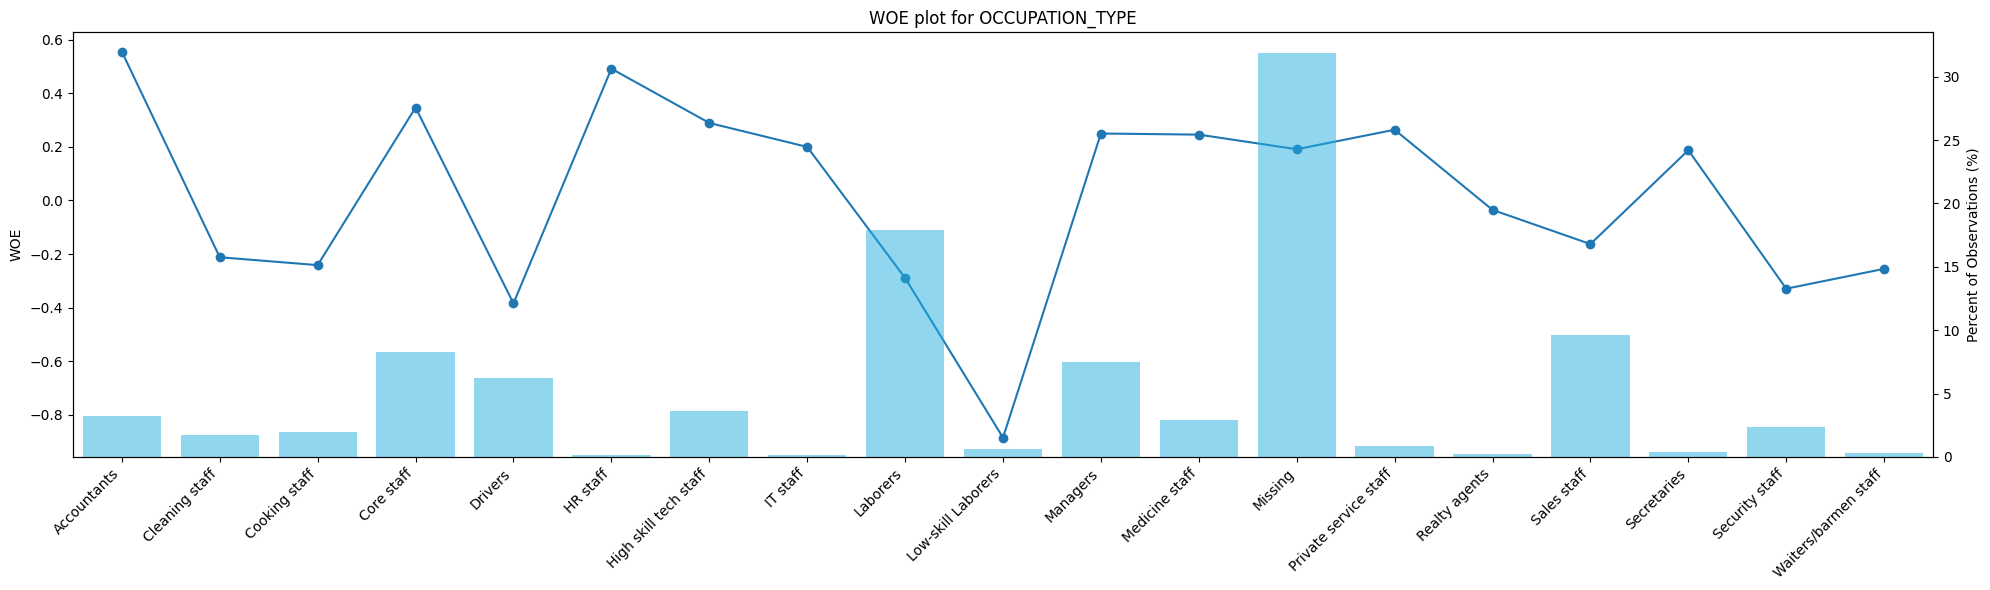

In [17]:
variable = 'OCCUPATION_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)

# Ensure TARGET is numeric 0/1 for the plot calc
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)

woe_iv_plot(woe_bin_data, variable)


## Coarse classing helper: 3 bands by WOE
- Compute WOE per category using your function.
- Sort categories by WOE (lower = riskier).
- Merge into 3 bands by **population tertiles** in WOE order:
  High (riskiest) → Moderate → Low (safest).


In [18]:
def coarse_bin_3bands(df, feature, target='TARGET',
                      labels=('High','Moderate','Low'), balance_by='Count'):
    """
    Build a 3-band coarse variable for one categorical feature by WOE order.
    Returns:
      - new_series: the 3-band labels aligned to df.index
      - mapping: per-category table with Count, EventRate, WOE, and assigned band
    """
    # 1) Build input for woe_iv
    tmp = df[[feature, target]].copy()
    tmp['Bin_Range'] = tmp[feature].astype('object').fillna('Missing')
    tmp[target] = pd.to_numeric(tmp[target], errors='coerce').fillna(0).astype(int)

    # 2) WOE per original category
    w = woe_iv(tmp)  # columns include: Bin_Range, Count, EventRate, WOE, ...

    # 3) Order by WOE (ascending: most negative → riskiest)
    w = w.sort_values('WOE', ascending=True).reset_index(drop=True)

    # 4) Assign bands: population-weighted tertiles by WOE rank
    if balance_by == 'Count':
        total = w['Count'].sum()
        w['cum_prop'] = w['Count'].cumsum() / total
        def _band(p):
            if p <= 1/3: return labels[0]   # High risk (lowest WOE)
            if p <= 2/3: return labels[1]   # Moderate
            return labels[2]                # Low risk (highest WOE)
        w['CoarseBand'] = w['cum_prop'].apply(_band)
    else:
        k = len(w); cut1, cut2 = k//3, 2*k//3
        w['CoarseBand'] = (['High']*cut1 + ['Moderate']*(cut2-cut1) + ['Low']*(k-cut2))

    # 5) Map original categories → band, return aligned series
    cat2band = dict(zip(w['Bin_Range'], w['CoarseBand']))
    new_col = f"{feature}_coarse3"
    new_series = tmp['Bin_Range'].map(cat2band).astype('category')
    new_series.index = df.index  # align to original df

    return new_series, w  # w is the category→band mapping table


=== OCCUPATION_TYPE → category → band mapping (by WOE) ===


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


,Bin_Range,Count,EventRate,WOE,CoarseBand
0,Low-skill Laborers,1647,0.166363,-0.885584,High
1,Drivers,15914,0.107955,-0.384206,High
2,Security staff,6024,0.102756,-0.329491,High
3,Laborers,45477,0.099171,-0.289379,High
4,Waiters/barmen staff,836,0.095694,-0.255305,High
5,Cooking staff,5100,0.094902,-0.241475,High
6,Cleaning staff,4351,0.092393,-0.212101,High
7,Sales staff,24520,0.088418,-0.162848,Moderate
8,Realty agents,590,0.077966,-0.035334,Moderate
9,Secretaries,976,0.063525,0.187461,Moderate


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for OCCUPATION_TYPE_coarse3 with 3 categories: 0.0714


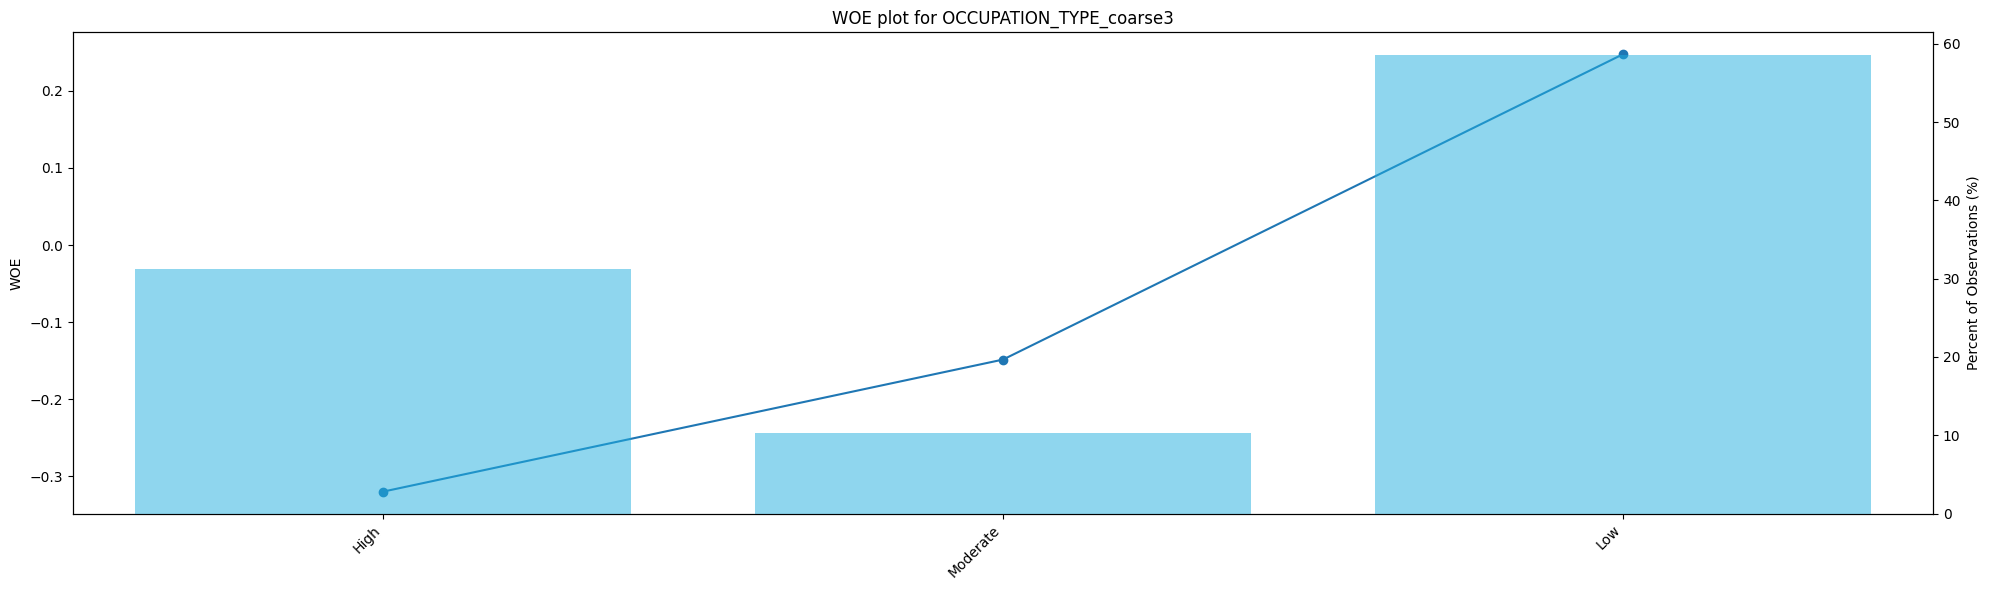

In [19]:
from IPython.display import display

# Create OCCUPATION_TYPE_coarse3
df['OCCUPATION_TYPE_coarse3'], occ_map = coarse_bin_3bands(
    df, feature='OCCUPATION_TYPE', target='TARGET',
    labels=('High','Moderate','Low'), balance_by='Count'
)

print("=== OCCUPATION_TYPE → category → band mapping (by WOE) ===")
display(occ_map[['Bin_Range','Count','EventRate','WOE','CoarseBand']])

# Plot WOE for the 3 bands (order forced inside plotter)
variable = 'OCCUPATION_TYPE_coarse3'
woe_bin_data = df.loc[:, (variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]   # keep as categorical
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)
woe_iv_plot(woe_bin_data, variable)


### NAME_INCOME_TYPE

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\22331280.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

IV for NAME_INCOME_TYPE with 8 categories: 0.0467


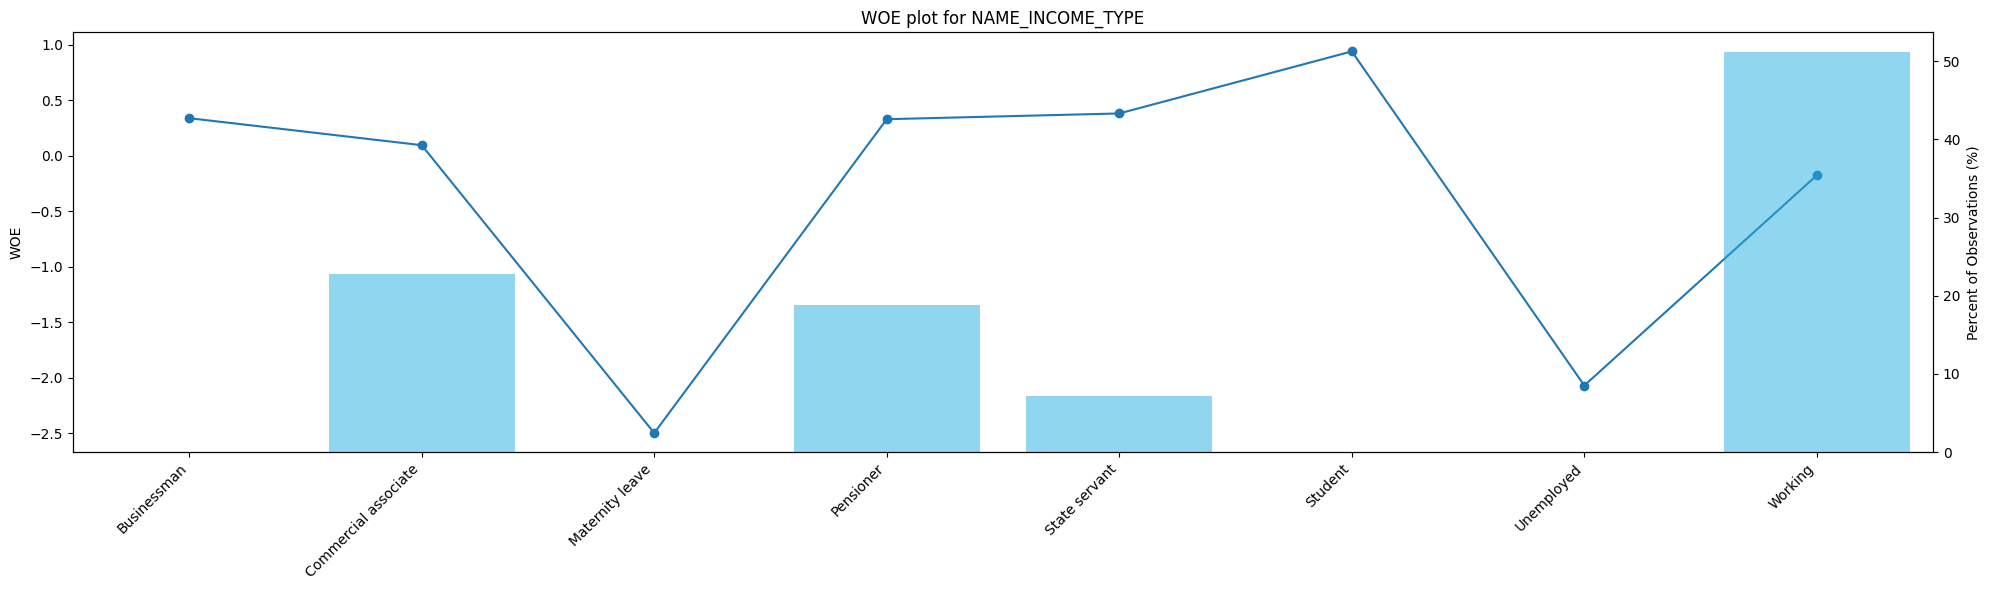

In [20]:
variable = 'NAME_INCOME_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)

# Ensure TARGET is numeric 0/1 for the plot calc
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)

woe_iv_plot(woe_bin_data, variable)


=== NAME_INCOME_TYPE → category → band mapping (by WOE) ===


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


,Bin_Range,Count,EventRate,WOE,CoarseBand
0,Maternity leave,4,0.500000,-2.496011,High
1,Unemployed,18,0.388889,-2.068567,High
2,Working,130097,0.089533,-0.176701,Moderate
3,Commercial associate,57926,0.069761,0.094235,Low
4,Pensioner,47937,0.056032,0.327986,Low
5,Businessman,8,0.000000,0.337203,Low
6,State servant,18353,0.053343,0.379706,Low
7,Student,15,0.000000,0.937977,Low


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for NAME_INCOME_TYPE_coarse3 with 3 categories: 0.0397


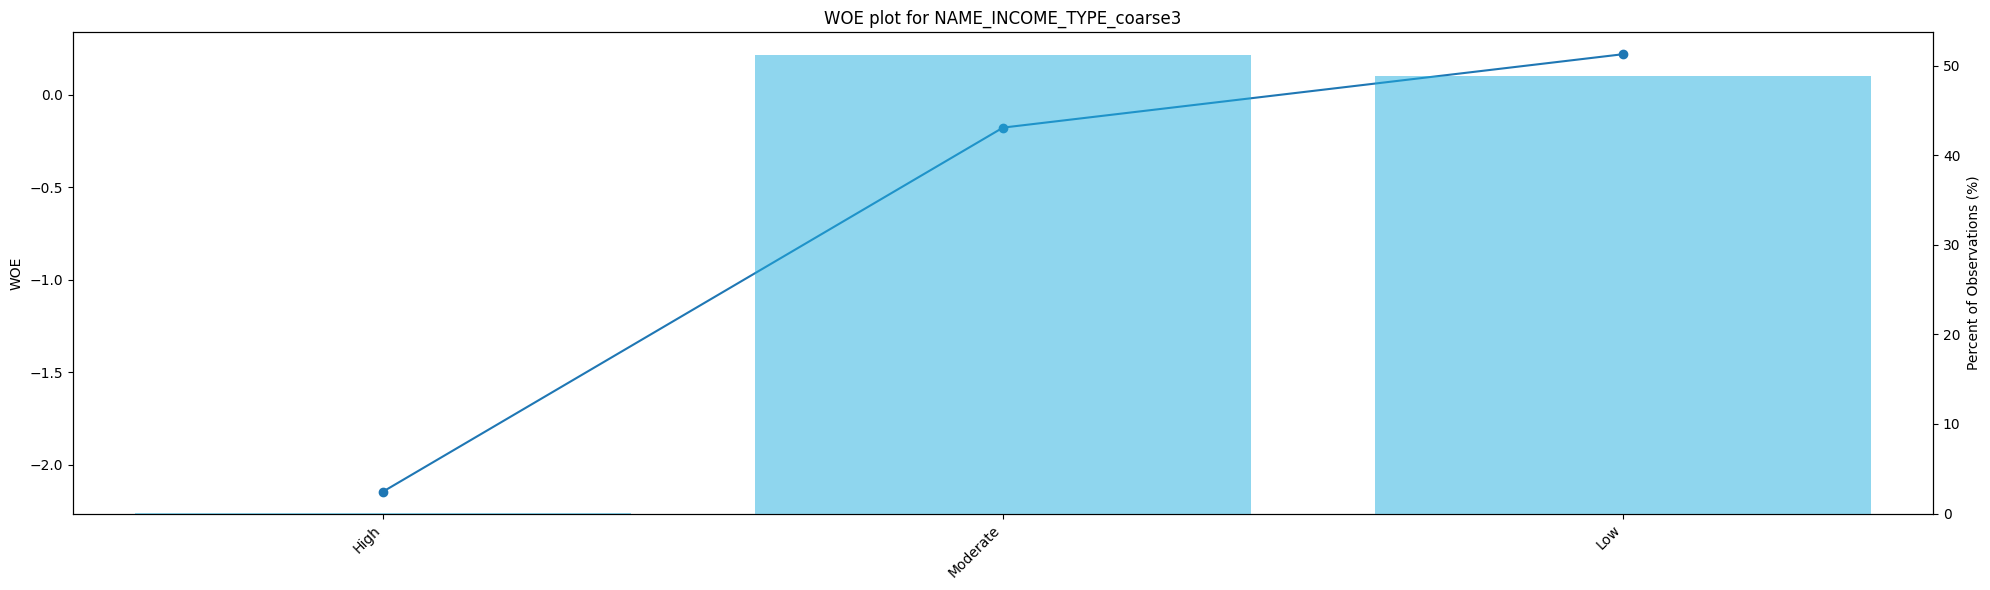

In [21]:
# Create NAME_INCOME_TYPE_coarse3
df['NAME_INCOME_TYPE_coarse3'], inc_map = coarse_bin_3bands(
    df, feature='NAME_INCOME_TYPE', target='TARGET',
    labels=('High','Moderate','Low'), balance_by='Count'
)

print("=== NAME_INCOME_TYPE → category → band mapping (by WOE) ===")
display(inc_map[['Bin_Range','Count','EventRate','WOE','CoarseBand']])

# Plot WOE for the 3 bands
variable = 'NAME_INCOME_TYPE_coarse3'
woe_bin_data = df.loc[:, (variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]   # keep as categorical
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)
woe_iv_plot(woe_bin_data, variable)


In [22]:
# Event-rate monotonicity
print("Event rate by OCCUPATION_TYPE_coarse3:")
print(df.groupby('OCCUPATION_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))

print("\nEvent rate by NAME_INCOME_TYPE_coarse3:")
print(df.groupby('NAME_INCOME_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))


Event rate by OCCUPATION_TYPE_coarse3:
OCCUPATION_TYPE_coarse3
High        0.101917
Moderate    0.087250
Low         0.060434
Name: TARGET, dtype: float64

Event rate by NAME_INCOME_TYPE_coarse3:
NAME_INCOME_TYPE_coarse3
High        0.409091
Moderate    0.089533
Low         0.062026
Name: TARGET, dtype: float64


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3217377041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('OCCUPATION_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3217377041.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('NAME_INCOME_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))


### NAME_FAMILY_STATUS

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\1802753599.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for NAME_FAMILY_STATUS with 6 categories: 0.0156


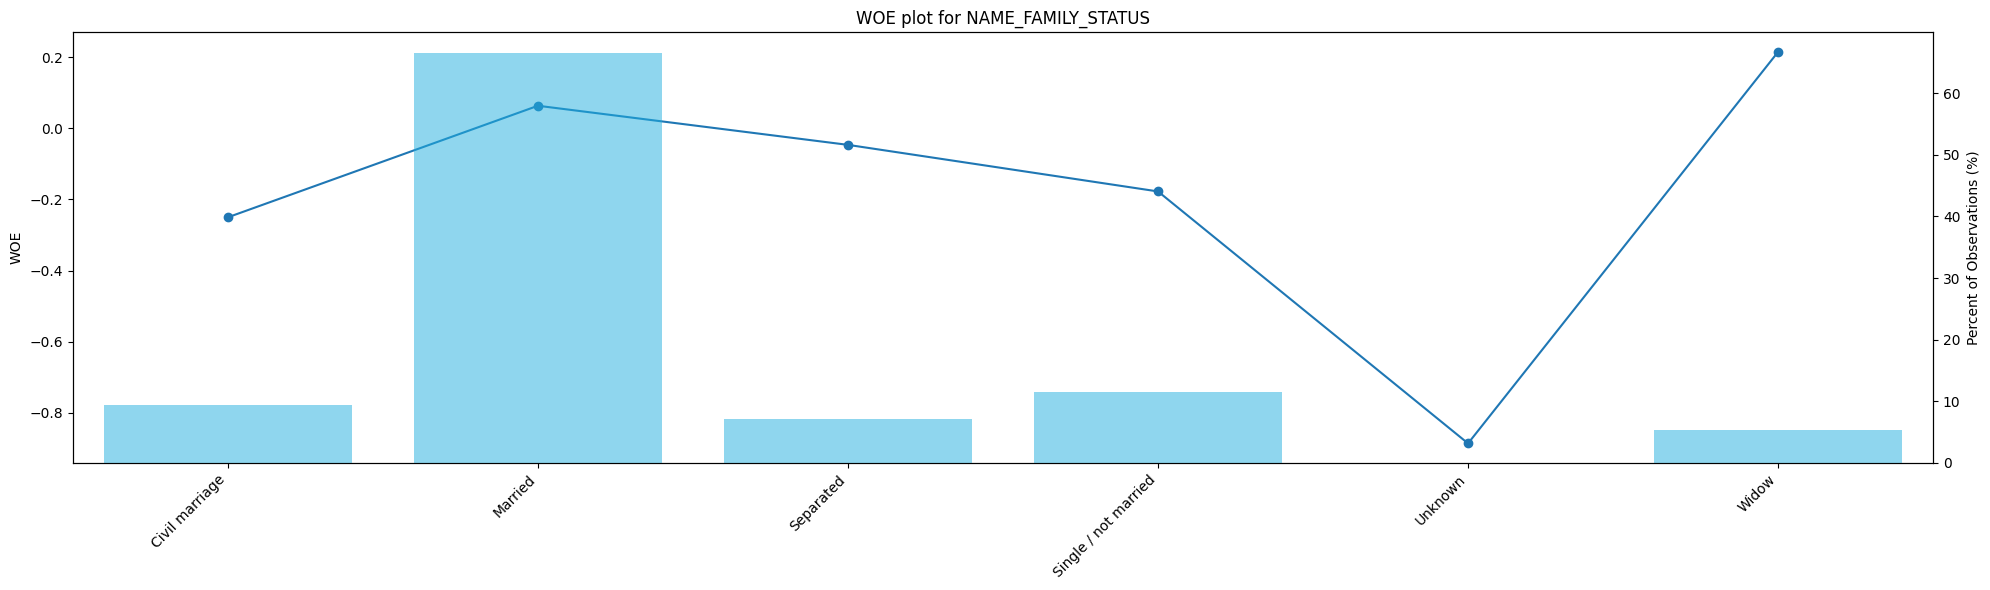

In [23]:
# test the function for categorical variable
variable = 'NAME_FAMILY_STATUS'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

In [24]:
df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,Bin_Range,OCCUPATION_TYPE_coarse3,NAME_INCOME_TYPE_coarse3
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Low,Low
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Moderate
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Moderate
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Moderate
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,-7258.0,Sales staff,N,Y,45.767123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate,Moderate
254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,NaN,NaN,N,Y,56.917808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low
254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,-7921.0,Managers,N,Y,41.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Moderate
254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,-4786.0,Laborers,N,Y,32.769863,45000.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,High,Low
